Dataset shape: (155, 28)
   Activity ID Activity Type   Begin Timestamp     End Timestamp  \
0   2284658991       Running  04/11/2017 12:07  04/11/2017 13:06   
1   2284658936       Running  03/11/2017 09:47  03/11/2017 10:35   
2   2228102647       Running  25/10/2017 16:31  25/10/2017 17:11   
3   2104984694       Running  13/10/2017 11:53  13/10/2017 12:41   
4   2084195352       Running  02/10/2017 14:51  02/10/2017 15:38   

   Max. Elevation (Raw)  Min. Elevation (Raw)  Elevation Gain (Raw)  \
0                 472.6                 472.6                 315.0   
1                 473.2                 473.2                 245.0   
2                 278.8                 278.8                 208.0   
3                 471.6                 471.6                 246.0   
4                 494.6                 494.6                 246.0   

   Elevation Loss (Raw)  Average Heart Rate (bpm)  Max. Heart Rate (bpm).1  \
0                 314.0                       182            

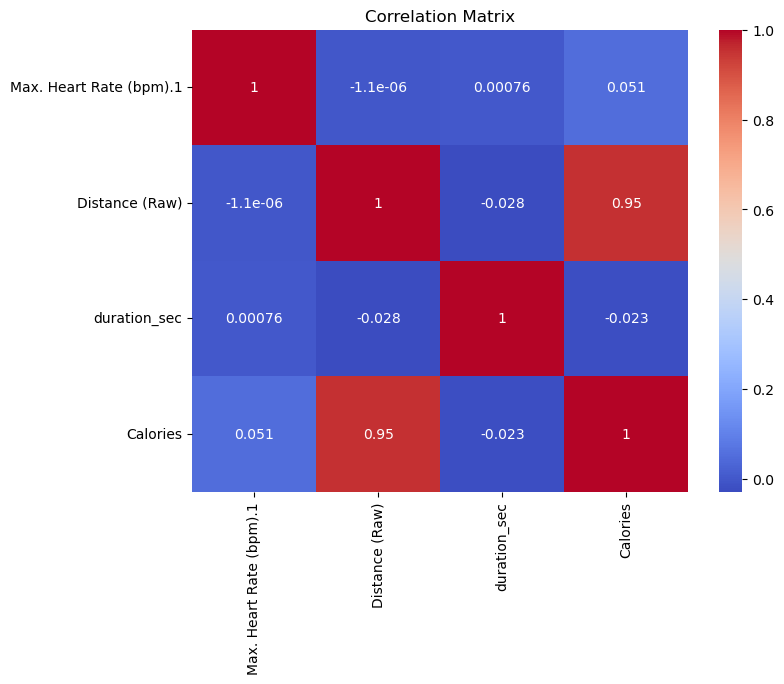


Average Calories Burned per Heart Rate Zone:
 HR_Zone
Zone 1    508.625000
Zone 2    575.741935
Zone 3    407.000000
Name: Calories, dtype: float64


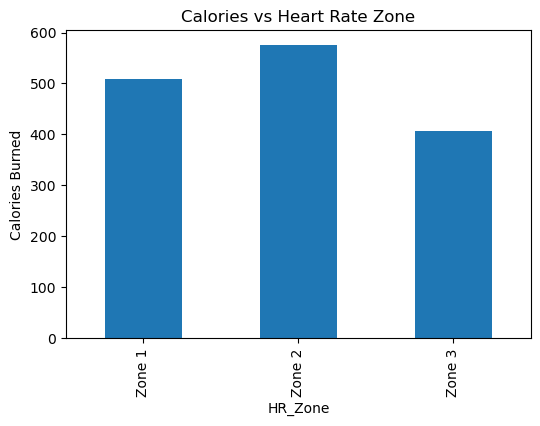

Linear Regression R2: 0.8980978642823836
Polynomial Regression R2: 0.39565979935417717
SVR R2: -0.07524731983032429
Random Forest R2: 0.9248953340693924

Model Performance (Best Fit → Least Fit):
Random Forest: R2 = 0.9249
Linear Regression: R2 = 0.8981
Polynomial Regression: R2 = 0.3957
SVR: R2 = -0.0752


C:\Users\siddh\AppData\Local\Temp\ipykernel_48040\146676036.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


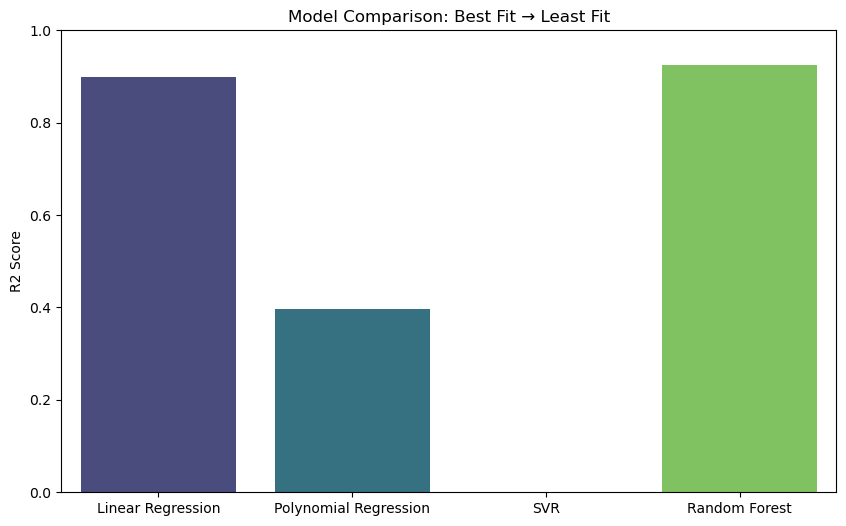

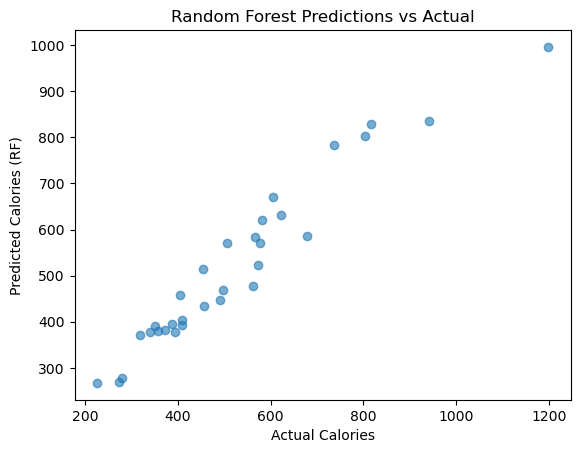

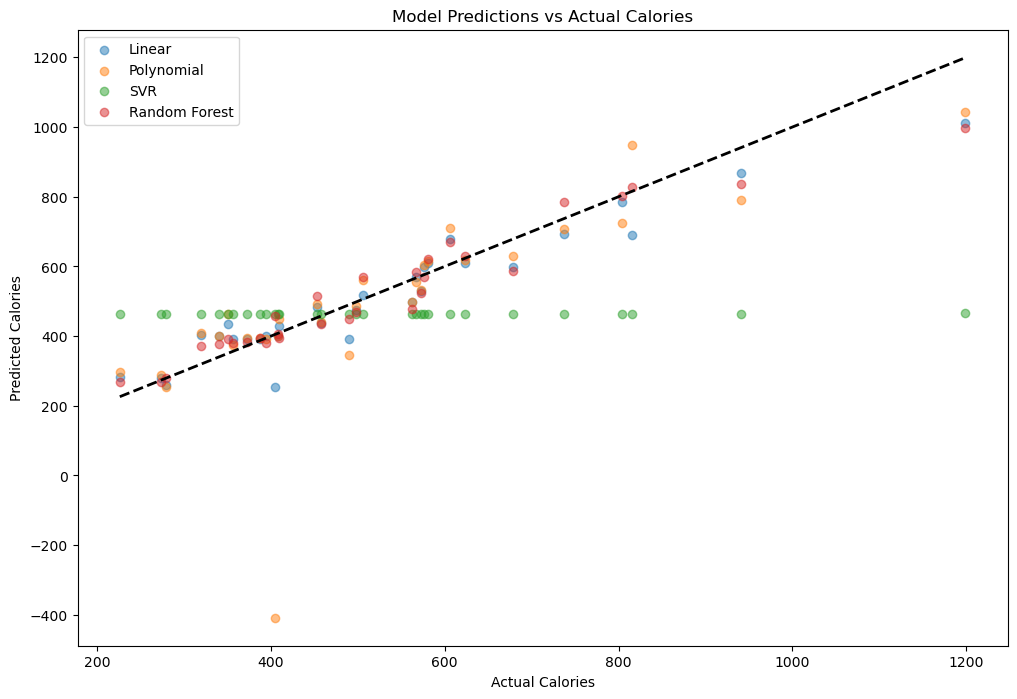


Seasonal mean metrics head:
    Year  Season  Distance (Raw)   duration_sec    Calories  \
0  2015       1        4.964110  432000.000000  401.000000   
1  2016       1        6.389524    2170.000000  501.111111   
2  2016       2        5.658520    3077.666667  442.166667   
3  2016       3        6.545250    2264.333333  528.777778   
4  2016       4        5.508600    1835.000000  431.000000   

   Max. Heart Rate (bpm).1  
0                97.000000  
1                95.222222  
2                98.666667  
3                93.666667  
4                96.333333  


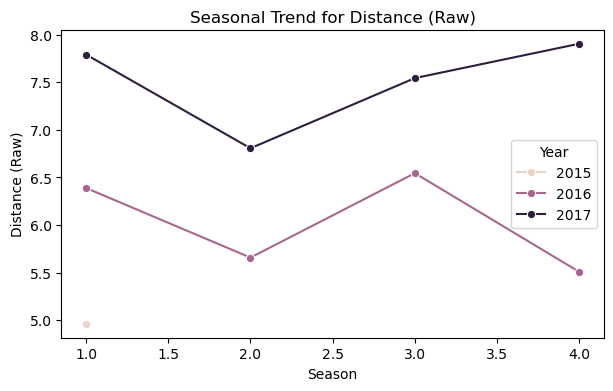

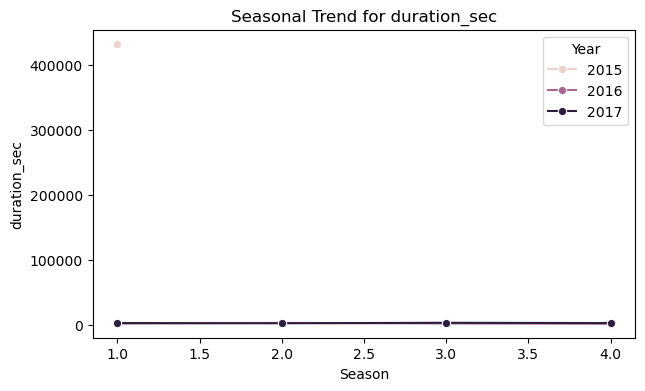

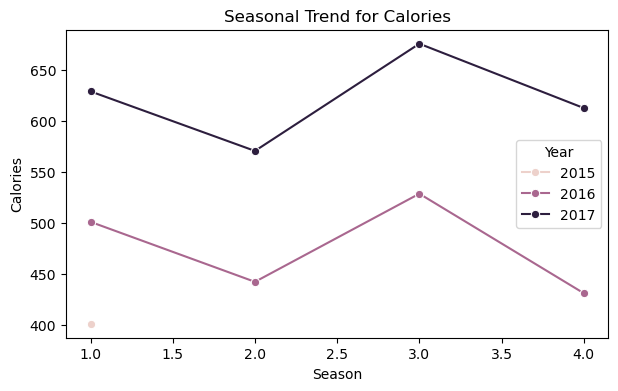

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 1. Load dataset
df = pd.read_csv("activities_cleaned 1.csv")
print("Dataset shape:", df.shape)
print(df.head())

# --- Column name mapping ---
HR_COL = 'Max. Heart Rate (bpm).1'
DIST_COL = 'Distance (Raw)'
DUR_COL = 'Moving Duration (h:m:s)'
CAL_COL = 'Calories'

# --- Clean numeric columns (remove commas, convert to numbers) ---
for col in [HR_COL, DIST_COL, CAL_COL]:
    df[col] = df[col].astype(str).str.replace(',', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Convert duration h:m:s → seconds ---
def hms_to_seconds(x):
    try:
        parts = str(x).split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h*3600 + m*60 + s
        elif len(parts) == 2:
            m, s = map(int, parts)
            return m*60 + s
        else:
            return np.nan
    except:
        return np.nan

df['duration_sec'] = df[DUR_COL].apply(hms_to_seconds)

# 2. Basic preprocessing
df = df.dropna(subset=[HR_COL, DIST_COL, CAL_COL, 'duration_sec'])
df = df[(df[HR_COL] > 40) & (df[HR_COL] < 220)]
df = df[df[DIST_COL] < df[DIST_COL].quantile(0.99)]

# 3. Exploratory Data Analysis (EDA)
plt.figure(figsize=(8,6))
sns.heatmap(df[[HR_COL, DIST_COL, 'duration_sec', CAL_COL]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Heart Rate Zone Analysis
def hr_zone(hr):
    if hr < 100:
        return 'Zone 1'
    elif hr < 130:
        return 'Zone 2'
    elif hr < 160:
        return 'Zone 3'
    elif hr < 180:
        return 'Zone 4'
    else:
        return 'Zone 5'

df['HR_Zone'] = df[HR_COL].apply(hr_zone)
zone_summary = df.groupby('HR_Zone')[CAL_COL].mean()
print("\nAverage Calories Burned per Heart Rate Zone:\n", zone_summary)

zone_summary.plot(kind='bar', figsize=(6,4), title="Calories vs Heart Rate Zone")
plt.ylabel("Calories Burned")
plt.show()

# 4. Predictive Modeling for Calories Burned
features = [HR_COL, 'duration_sec', DIST_COL]
target = CAL_COL

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression R2:", r2_lr)

# Polynomial Regression (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
pr = LinearRegression()
pr.fit(X_train_poly, y_train)
y_pred_pr = pr.predict(X_test_poly)
r2_pr = r2_score(y_test, y_pred_pr)
print("Polynomial Regression R2:", r2_pr)

# Support Vector Regression
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR R2:", r2_svr)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest R2:", r2_rf)

# --- Compare all models ---
r2_scores = {
    'Linear Regression': r2_lr,
    'Polynomial Regression': r2_pr,
    'SVR': r2_svr,
    'Random Forest': r2_rf
}

print("\nModel Performance (Best Fit → Least Fit):")
for model, score in sorted(r2_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: R2 = {score:.4f}")

# --- Plot comparison ---
plt.figure(figsize=(10,6))
models = list(r2_scores.keys())
scores = [r2_scores[m] for m in models]
sns.barplot(x=models, y=scores, palette="viridis")
plt.ylabel("R2 Score")
plt.title("Model Comparison: Best Fit → Least Fit")
plt.ylim(0,1)
plt.show()

# Visualization of Model Predictions (Random Forest)
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories (RF)")
plt.title("Random Forest Predictions vs Actual")
plt.show()

# Combined scatter plot for all models
plt.figure(figsize=(12,8))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear')
plt.scatter(y_test, y_pred_pr, alpha=0.5, label='Polynomial')
plt.scatter(y_test, y_pred_svr, alpha=0.5, label='SVR')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Model Predictions vs Actual Calories")
plt.legend()
plt.show()

# 5. VO2 Max Modeling (if available)
if 'vo2_max' in df.columns and 'ftp' in df.columns:
    X_vo2 = df[['ftp']]
    y_vo2 = df['vo2_max']
    
    X_train_vo2, X_test_vo2, y_train_vo2, y_test_vo2 = train_test_split(X_vo2, y_vo2, test_size=0.2, random_state=42)

    lr_vo2 = LinearRegression()
    lr_vo2.fit(X_train_vo2, y_train_vo2)
    y_pred_vo2 = lr_vo2.predict(X_test_vo2)
    print("VO2 Max Linear Regression R2:", r2_score(y_test_vo2, y_pred_vo2))

    svr_vo2 = SVR(kernel='rbf')
    svr_vo2.fit(X_train_vo2, y_train_vo2)
    y_pred_vo2_svr = svr_vo2.predict(X_test_vo2)
    print("VO2 Max SVR R2:", r2_score(y_test_vo2, y_pred_vo2_svr))

    plt.scatter(y_test_vo2, y_pred_vo2, alpha=0.6, label='Linear')
    plt.scatter(y_test_vo2, y_pred_vo2_svr, alpha=0.6, label='SVR')
    plt.xlabel("Actual VO2 Max")
    plt.ylabel("Predicted VO2 Max")
    plt.title("VO2 Max Prediction")
    plt.legend()
    plt.show()

# 6. Seasonal Analysis (Running & Cycling)
def _detect_datetime_column(columns):
    candidates = [c for c in columns if any(k in c.lower() for k in ['date', 'time', 'start'])]
    return candidates[0] if candidates else None

def _detect_type_column(columns):
    candidates = [c for c in columns if any(k in c.lower() for k in ['activity', 'sport', 'type', 'category'])]
    return candidates[0] if candidates else None

dt_col = _detect_datetime_column(df.columns)
act_col = _detect_type_column(df.columns)

if dt_col is None:
    print("No datetime-like column found. Seasonal analysis requires a date/time column.")
else:
    df_sa = df.copy()
    df_sa[dt_col] = pd.to_datetime(df_sa[dt_col], errors='coerce')
    df_sa = df_sa.dropna(subset=[dt_col])
    df_sa['Year'] = df_sa[dt_col].dt.year
    df_sa['Month'] = df_sa[dt_col].dt.month
    df_sa['Season'] = df_sa[dt_col].dt.month % 12 // 3 + 1

    metric_candidates = [m for m in [DIST_COL,'duration_sec',CAL_COL,HR_COL] if m in df_sa.columns]
    if metric_candidates:
        seasonal = df_sa.groupby(['Year','Season'])[metric_candidates].mean().reset_index()
        print("\nSeasonal mean metrics head:\n", seasonal.head())
        for m in metric_candidates[:3]:
            plt.figure(figsize=(7,4))
            sns.lineplot(data=seasonal, x='Season', y=m, hue='Year', marker='o')
            plt.title(f'Seasonal Trend for {m}')
            plt.show()

# 7. Running vs Cycling Comparison
labels_map = {
    'run': ['run','running','jog'],
    'ride': ['ride','cycling','cycle','bike']
}

run_df, ride_df = None, None
if act_col is not None:
    low = df[act_col].astype(str).str.lower()
    run_mask = low.apply(lambda x: any(k in x for k in labels_map['run']))
    ride_mask = low.apply(lambda x: any(k in x for k in labels_map['ride']))
    run_df = df[run_mask].copy()
    ride_df = df[ride_mask].copy()

if run_df is None or run_df.empty:
    run_df = pd.DataFrame(columns=df.columns)
if ride_df is None or ride_df.empty:
    ride_df = pd.DataFrame(columns=df.columns)

compare_metrics = [m for m in [DIST_COL,'duration_sec',CAL_COL,HR_COL] if m in df.columns]

def describe_block(name, frame):
    if frame is None or frame.empty:
        print(f"No data for {name}.")
        return
    print(f"\n{name} summary (first 5 rows):\n", frame[compare_metrics].head())
    desc = frame[compare_metrics].describe().T
    print(f"\n{name} describe:\n", desc)

    req = [c for c in [HR_COL,'duration_sec',DIST_COL] if c in frame.columns]
    if CAL_COL in frame.columns and len(req) >= 2 and len(frame) > 20:
        Xs = frame[req]
        ys = frame[CAL_COL]
        Xtr, Xte, ytr, yte = train_test_split(Xs, ys, test_size=0.2, random_state=42)
        rf_s = RandomForestRegressor(n_estimators=200, random_state=42).fit(Xtr, ytr)
        yhat = rf_s.predict(Xte)
        print(f"{name} RF Calories R2:", r2_score(yte, yhat))
        plt.figure(figsize=(6,4))
        plt.scatter(yte, yhat, alpha=0.6)
        plt.xlabel('Actual Calories')
        plt.ylabel('Predicted Calories (RF)')
        plt.title(f'{name}: RF Pred vs Actual (Calories)')
        plt.show()
